In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf

In [2]:
def Convolution(input_tensor, filters, kernel_size, pool_type='max'):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if pool_type == 'max':
        x = MaxPooling2D(pool_size=(2, 2))(x)
    else:
        x = AveragePooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    return x

In [3]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    return x

In [4]:
def model_f(input_shape):
    inputs = Input(input_shape)

    conv_1 = Convolution(inputs, 64, (3, 3), 'max')
    conv_2 = Convolution(conv_1, 128, (5, 5), 'max')
    conv_3 = Convolution(conv_2, 64, (3,3), 'max')
    
    gap = Flatten()(conv_3)
    dense_0 = Dense_f(gap, 128)
    
    output = Dense(2, activation="softmax")(dense_0)
    model = Model(inputs=inputs, outputs=output)

    optimizer = Adam(learning_rate=0.0005)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [5]:
model = model_f((64,64,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0     

In [6]:
image_size = 64
batch_size = 64
epochs = 100

datagen_train = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = datagen_train.flow_from_directory(
    "GenData/Train/",
    target_size=(image_size, image_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

datagen_validation = ImageDataGenerator(rescale=1./255)

validation_generator = datagen_validation.flow_from_directory(
    "GenData/Test/",
    target_size=(image_size, image_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 47009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


In [7]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)

epochs = 20
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("gender_model_weightsnew.h5", monitor='val_accuracy', save_weights_only = True, mode = 'max', verbose = 1)
callbacks = [checkpoint, early_stopping, reduce_lr]

In [8]:
history = model.fit(
    x = train_generator, 
    steps_per_epoch = steps_per_epoch, 
    epochs = epochs, 
    validation_data = validation_generator, 
    validation_steps = validation_steps, 
    callbacks = callbacks
)

Epoch 1/20
734/734 [==============================] - ETA: 0s - loss: 0.4105 - accuracy: 0.8205
Epoch 1: saving model to gender_model_weightsnew.h5
734/734 [==============================] - 937s 1s/step - loss: 0.4105 - accuracy: 0.8205 - val_loss: 0.2048 - val_accuracy: 0.9204 - lr: 5.0000e-04
Epoch 2/20
734/734 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9067
Epoch 2: saving model to gender_model_weightsnew.h5
734/734 [==============================] - 932s 1s/step - loss: 0.2375 - accuracy: 0.9067 - val_loss: 0.1677 - val_accuracy: 0.9380 - lr: 5.0000e-04
Epoch 3/20
734/734 [==============================] - ETA: 0s - loss: 0.2029 - accuracy: 0.9232
Epoch 3: saving model to gender_model_weightsnew.h5
734/734 [==============================] - 939s 1s/step - loss: 0.2029 - accuracy: 0.9232 - val_loss: 0.2044 - val_accuracy: 0.9138 - lr: 5.0000e-04
Epoch 4/20
734/734 [==============================] - ETA: 0s - loss: 0.1877 - accuracy: 0.9295
Epoch 4: savi

In [9]:
model.evaluate(validation_generator)

183/183 [==============================] - 39s 210ms/step - loss: 0.0847 - accuracy: 0.9683


[0.08467657119035721, 0.9683234691619873]

In [10]:
model_json = model.to_json()
with open("model_gendernew.json","w") as json_file:
    json_file.write(model_json)

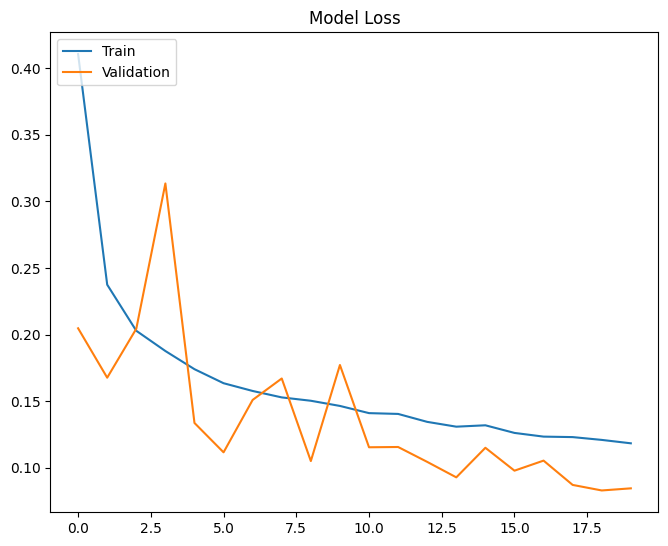

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc="upper left")
plt.subplots_adjust(top=1.0,bottom=0.0, right=0.95,left=0.0,hspace=0.25,wspace=0.35)

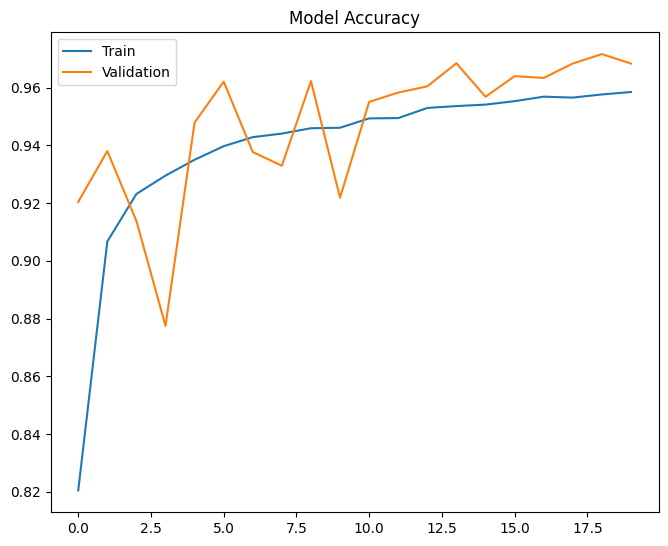

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc="upper left")
plt.subplots_adjust(top=1.0,bottom=0.0, right=0.95,left=0.0,hspace=0.25,wspace=0.35)